- 합성곱 신경망을 이용한 문장 분류 (classification)
- 문장 예시- I am a teacher. 
- 단어가 4개가 있다. 각각의 행을 만들어 행 안에 단어를 넣는다. 열의 갯수는 문장 중에서 가장 길이가 긴 단어의 길이로 하고, 부족하면 0으로 채워 (padding) 행렬을 만든다. (이제 이것을 conv2d에 넣으면 된다.)
각 단어가 하나의 행을 의미하기 때문에 이 행 자체가 벡터가 된다.


In [35]:
from tensorflow.keras.models     import Sequential, Model
from tensorflow.keras.layers     import Activation , Dense , BatchNormalization, Embedding, Dropout ,Flatten, Conv2D, MaxPooling2D , AveragePooling2D , GlobalMaxPooling2D , ZeroPadding2D , Input, Conv1D, MaxPooling1D, Reshape, concatenate
from tensorflow.keras.optimizers import SGD , Adam , RMSprop
from tensorflow.keras.utils      import plot_model , to_categorical
from tensorflow.keras.callbacks  import EarlyStopping , ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection     import train_test_split
from sklearn.preprocessing       import StandardScaler , MinMaxScaler , LabelEncoder
from sklearn.model_selection     import KFold
from sklearn.ensemble            import VotingClassifier
from sklearn.metrics             import accuracy_score

import matplotlib.pyplot as plt

import pandas  as pd
import numpy   as np
import seaborn as sns

# dataset
from tensorflow.keras.datasets import imdb #영화 review를 담고 있는 dataset

#from tensorflow.keras.datasets   import cifar10 , mnist
# from tensorflow.keras.datasets.mnist import load_data
# from tensorflow.keras.datasets.fashion_mnist import load_data
# from sklearn.datasets            import load_breast_cancer
#from sklearn.datasets            import load_digits

In [2]:
#감성 분석 (긍정의 리뷰인지 부정의 리뷰인지 분류해보자)

In [8]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words= 3000) #빈도수가 높은 단어 3000개만 #옵션 주기 가능
#keras에서 제공하는 데이터를 가져올 때는 load_data사용. (타 데이터셋과 중복되게 load 불가)
#데이터 양이 너무 많기 때문에 중복의 갯수를 세서 빈도수가 높은 단어들만 포함을 시켜 가져올 것. (+문장의 길이 제한/ dimension 제한 추가)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
X_train[0] #피쳐 찍어보기 #문장이 들어있고 (1, 14, 22....어쩌구 수많은 숫자들이 들어있다.)

In [9]:
y_train[0] #문장이 긍정인지 부정인지에 대한 0, 1값이 들어있다. (둘 중 하나이기 때문에 categorical이 아닌 binary)

1

- BOW(back of word)를 통해 문장, 단어를 수치로 바꿔준다. (컴퓨터는 수치밖에 인식하지 못하기 때문에.)

In [14]:
#pad sequence를 통해 피쳐의 갯수를 맞춰준다.
X_train= pad_sequences(X_train, maxlen= 300) #문장의 길이를 최대 300자 단어 제한 #300이 안되는 문장의 경우 비어있는 공간이 자동으로 0으로 채워진다.
X_test= pad_sequences(X_test, maxlen= 300)

X_train.shape, X_test.shape, y_train.shape, y_test.shape #300개로 맞춰졌다. #피쳐들이 300개를 갖는 벡터 형식인 것이지 2d형식이 아니다.
# 이 때 conv2d, conv1d 둘 다 사용할 수 있다.

((25000, 300), (25000, 300), (25000,), (25000,))

- conv1d를 사용해본다면

In [18]:
# 1-D Conv

def sentence_cnn_1d() :
  model= Sequential()

  #feature extraction
  #각각의 단어들이 벡터화 되어 있어야 되기 때문에 embedding을 통해서 벡터로 풀어준다.
  model.add(Embedding(input_dim= 3000, output_dim= 100, input_length= 300)) #100개 정도로 추려주는 것 #input_length는 위에서 준 maxlen과 일치해야 한다.
  model.add(Conv1D(filters= 50, kernel_size= 5, strides= 1, padding= 'valid')) #embedding된 것을 여기 넣어준다 #5개씩 단어를 끊어오겠다는 것= N gram
  model.add(MaxPooling1D(2, padding= 'valid'))

  model.add(Flatten()) 

  #여기서부터는 classification
  model.add(Dense(10))
  model.add(Activation('relu'))

  #output layer
  model.add(Dense(1)) #0또는 1이기 때문에 이진분류
  model.add(Activation('sigmoid')) #softmax가 아닌 sigmoid 사용

  #모델 컴파일을 위해 optimizer
  adam= Adam(lr= 0.001)
  model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy']) #이진분류이기 때문에

  return model

In [19]:
model= sentence_cnn_1d()

In [21]:
history= model.fit(X_train, y_train, batch_size= 50, validation_split=0.2, epochs= 10, verbose= 1)

Epoch 1/10
400/400 [==============================] - 5s 13ms/step - loss: 0.2458 - accuracy: 0.8992 - val_loss: 0.2973 - val_accuracy: 0.8766
Epoch 2/10
400/400 [==============================] - 5s 13ms/step - loss: 0.1693 - accuracy: 0.9371 - val_loss: 0.3348 - val_accuracy: 0.8682
Epoch 3/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0712 - accuracy: 0.9792 - val_loss: 0.4644 - val_accuracy: 0.8472
Epoch 4/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0216 - accuracy: 0.9944 - val_loss: 0.6044 - val_accuracy: 0.8612
Epoch 5/10
400/400 [==============================] - 5s 13ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 0.6999 - val_accuracy: 0.8622
Epoch 6/10
400/400 [==============================] - 5s 12ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.8154 - val_accuracy: 0.8584
Epoch 7/10
400/400 [==============================] - 5s 12ms/step - loss: 3.3689e-04 - accuracy: 1.0000 - val_loss: 0.8132 - val_accuracy: 0.

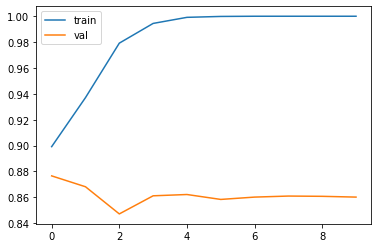

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='best')
plt.show() #train 데이터와 validation의 격차가 크다= overfitting (실제 정확도는 86% 정도)

In [24]:
result= model.evaluate(X_test, y_test) #실제 unseen data인 test 결과
print('acc', result[1])

782/782 [==============================] - 3s 4ms/step - loss: 0.8753 - accuracy: 0.8666
acc 0.8665599822998047


--------
- 위의 것을 2D 형식으로 만들어본다면

In [29]:
# 2-D Conv

def sentence_cnn_2d() :
  model= Sequential()

  #feature extraction
  model.add(Embedding(input_dim= 3000, output_dim= 100, input_length= 300)) # 300x 100을 만들면 된다.
  #벡터로 되어있는 것을 2차원의 행렬 방식으로 만들어줘야 한다. (2D)
  model.add( Reshape((300, 100, 1), input_shape= (300, 100)) ) #embedding과 reshape하는 것 까지가! input이다. #300x100의 2d 행렬 완성 2-D Conv

  model.add(Conv2D(filters= 50, kernel_size= (5, 100), strides= (1, 1), padding= 'valid')) 
  model.add(GlobalMaxPooling2D()) #global을 쓰면 flatten이 필요없다. (average, 그냥 max와 차이) # MaxPooling2D((2, 2), padding= 'valid') 이것도 가능.

  #model.add(Flatten()) 

  #classification
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.3)) #batchnormalization 등 가능

  #2
  model.add(Dense(10))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  #output layer
  model.add(Dense(1))
  model.add(Activation('sigmoid')) 

  #compile
  adam= Adam(lr= 0.001)
  model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy']) 

  return model

In [30]:
model= sentence_cnn_2d()
history= model.fit(X_train, y_train, batch_size= 50, validation_split=0.2, epochs= 10, verbose= 1)

Epoch 1/10
400/400 [==============================] - 8s 19ms/step - loss: 0.6420 - accuracy: 0.5985 - val_loss: 0.3501 - val_accuracy: 0.8558
Epoch 2/10
400/400 [==============================] - 8s 19ms/step - loss: 0.3562 - accuracy: 0.8740 - val_loss: 0.3008 - val_accuracy: 0.8772
Epoch 3/10
400/400 [==============================] - 8s 19ms/step - loss: 0.2608 - accuracy: 0.9192 - val_loss: 0.2995 - val_accuracy: 0.8818
Epoch 4/10
400/400 [==============================] - 7s 19ms/step - loss: 0.1837 - accuracy: 0.9480 - val_loss: 0.3196 - val_accuracy: 0.8736
Epoch 5/10
400/400 [==============================] - 8s 19ms/step - loss: 0.1445 - accuracy: 0.9642 - val_loss: 0.3431 - val_accuracy: 0.8778
Epoch 6/10
400/400 [==============================] - 8s 19ms/step - loss: 0.1017 - accuracy: 0.9765 - val_loss: 0.4552 - val_accuracy: 0.8776
Epoch 7/10
400/400 [==============================] - 8s 19ms/step - loss: 0.0728 - accuracy: 0.9854 - val_loss: 0.5609 - val_accuracy: 0.8694

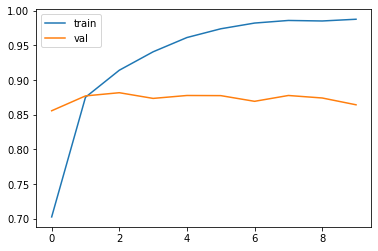

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='best')
plt.show() #과대적합에 대한 경고

In [32]:
result= model.evaluate(X_test, y_test) #val 평가값과 유사한 결과
print('acc', result[1])

782/782 [==============================] - 7s 8ms/step - loss: 0.6081 - accuracy: 0.8625
acc 0.8625199794769287


----------

In [33]:
# Dropout, Batch Normalization을 통해 모델의 성능을 안정화

In [45]:
# 2-D Conv

#합성곱 연산을 적용하는 레이어를 여러개 만들어서 성능을 개선하는 쪽에 focus
def conv_ary() :
  conv_layer_ary= []
  inn= Input(shape= (300, 100, 1)) #기존 코드와 달리 reshape이 된 이후 input을 받아 적용시키지만, 지금은 떨어져 있어 적용이 안되기 때문에 따로 받아준다. #reshape시 사용한 shape 사용
  #input 아님. error 주의! Input(o)

  size= [2, 3, 4, 5] #행의 갯수 #kernel_size를 바꿔보기 위해. 기존-(5, 100)

  #루프 안에서 conv에 append
  for s in size:
    conv= Conv2D(filters= 100, kernel_size= (s, 100), strides= (1,1), padding= 'valid')(inn) #우선 객체 생성
    act= Activation('relu')(conv) #<-input
    #모델에 바로 적용하지 않고 만들게 되면, 함수형 api
    pool= MaxPooling2D(pool_size= (300 -s +1, 1), padding= 'valid')(act) #그냥 임의적으로 pool size가 바뀌게 (원칙 존재x)

    conv_layer_ary.append(pool)
    
  out= concatenate(conv_layer_ary)
  model= Model(inputs= inn, outputs= out)

  return model

def improve_sentence_cnn_2d() :
  model= Sequential()

  #feature extraction
  model.add(Embedding(input_dim= 3000, output_dim= 100, input_length= 300)) 
  model.add( Reshape((300, 100, 1), input_shape= (300, 100)) )
  model.add(Dropout(0.5)) #Dropout 안에 숫자 파라미터 안주는 것 주의 error

  model.add(conv_ary()) #밑 코드 대신 위의 함수 사용해보기
  #model.add(Conv2D(filters= 50, kernel_size= (5, 100), strides= (1, 1), padding= 'valid')) 
  #model.add(MaxPooling2D()) 

  model.add(Flatten()) 

  #classification
  model.add(Dense(10))
  model.add(BatchNormalization()) #활성화 함수 적용 전 가능
  model.add(Activation('relu'))
  model.add(Dropout(0.3)) 

  #2
  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.3))

  #output layer
  model.add(Dense(1))
  model.add(Activation('sigmoid')) 

  #compile
  adam= Adam(lr= 0.001)
  model.compile(loss= 'binary_crossentropy', optimizer= adam, metrics= ['accuracy']) 

  return model

In [46]:
model= improve_sentence_cnn_2d()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 100)          300000    
_________________________________________________________________
reshape_6 (Reshape)          (None, 300, 100, 1)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 300, 100, 1)       0         
_________________________________________________________________
model_1 (Functional)         (None, 1, 1, 400)         140400    
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                4010      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10)               

In [47]:
#fit 할 때 callback을 줘서 early stopping하는 것도 가능

callbacks= [EarlyStopping(monitor= 'val_accuracy', patience= 3)] #history에서 모니터할 키 선택 #좋은 성능에서 떨어지는 횟수가 몇 번일때 멈출 것인지
history= model.fit(X_train, y_train, batch_size= 50, validation_split=0.2, epochs= 20, verbose= 1, callbacks= callbacks)

Epoch 1/20
400/400 [==============================] - 31s 72ms/step - loss: 0.6561 - accuracy: 0.6143 - val_loss: 0.5706 - val_accuracy: 0.6498
Epoch 2/20
400/400 [==============================] - 29s 72ms/step - loss: 0.4008 - accuracy: 0.8281 - val_loss: 0.3149 - val_accuracy: 0.8664
Epoch 3/20
400/400 [==============================] - 29s 72ms/step - loss: 0.3214 - accuracy: 0.8739 - val_loss: 0.3201 - val_accuracy: 0.8692
Epoch 4/20
400/400 [==============================] - 29s 73ms/step - loss: 0.2825 - accuracy: 0.8941 - val_loss: 0.3029 - val_accuracy: 0.8786
Epoch 5/20
400/400 [==============================] - 29s 73ms/step - loss: 0.2537 - accuracy: 0.9051 - val_loss: 0.2985 - val_accuracy: 0.8714
Epoch 6/20
400/400 [==============================] - 29s 73ms/step - loss: 0.2393 - accuracy: 0.9106 - val_loss: 0.2807 - val_accuracy: 0.8904
Epoch 7/20
400/400 [==============================] - 29s 73ms/step - loss: 0.2168 - accuracy: 0.9230 - val_loss: 0.2958 - val_accuracy:

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='best')
plt.show() 

In [32]:
result= model.evaluate(X_test, y_test) 
print('acc', result[1])